### Описание датасета
-  Регион - субъект Российской Федерации, где находится медицинское учреждение
-  Календарный_год - год
-  Период - месяц
-  gender - пол респондента
-  poselenie - ответ на вопрос "Вы постоянно проживаете в городе или в сельской местности?"
-  Населенный_пункт - название населенного пункта, где находится медицинское учреждение
-  org_type - ответ на вопрос "В каких организациях Вы обычно получаете медицинскую помощь?"
-  last_visit - ответ на вопрос "Как давно Вы в последний раз получали медицинскую помощь?"
-  time_of_register - ответ на вопрос "Насколько Вы согласны с утверждением, что сейчас Вы можете записаться к врачу в удобное для Вас время?"
-  wait_time - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания медицинской услуги с момента возникновения потребности в медицинской помощи до момента ее получения?"
-  near_cab - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания непосредственно перед кабинетом?"
-  comfort - ответ на вопрос "Насколько комфортным было Ваше пребывание в медицинской организации (комфортность зон ожидания, комфортное перемещение внутри медицинской организации)?"
-  attitude - ответ на вопрос "Насколько Вы удовлетворены отношением к Вам со стороны медицинского персонала (врачи, мед. сестры, регистраторы, санитары)?"
-  explain - ответ на вопрос "Удовлетворены ли Вы тем, как врач объяснял Вам, зачем назначено то или иное лечение, лекарственный препарат, диагностическая процедура?"
-  expect - ответ на вопрос "Насколько результат Вашего обращения в медицинскую организацию соответствовал Вашим ожиданиям?"
-  loyalty - ответ на вопрос "Вы бы посоветовали близким друзьям или родственникам обращаться за медицинской помощью в Вашу медицинскую организацию?"
-  gen_sat - ответ на вопрос "Оцените, насколько в целом Вы удовлетворены медицинской помощью?"
-  open_question_1 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в медицинской организации, в которой Вы получаете медицинскую помощь?"
-  open_question_2 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в регионе, в котором Вы проживаете?"
-  date_of_survey - дата опроса
-  respondent_number - номер респондента
-  doctor_domestic_visit_problem - ответ на вопрос "Возникали ли у Вас сложности при вызове врача на дом?"
-  diag_services_available - ответ на вопрос "Можете ли Вы получить при оказании первичной медико-санитарной помощи в Вашей медицинской организации диагностические и лабораторные услуги?"
-  disabled_facilitites_available - ответ на вопрос "Есть ли в Вашей медицинской организации приспособления для лиц с ограниченными возможностями?

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn
import os
from datetime import datetime
from category_encoders import TargetEncoder
from category_encoders.wrapper import PolynomialWrapper
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [26]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [4]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test, params=None):
    """
    Обучает модель и логирует в MLflow
    """
    with mlflow.start_run(run_name=model_name):
        if params:
            grid = GridSearchCV(model, params, cv=5, scoring='accuracy')
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_test)
            print(f"\nBest parameters for {model_name}:", grid.best_params_)
        else:
            best_model = model
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1_score = report['1']['f1-score']

        mlflow.log_param("model", model_name)
        if params:
            mlflow.log_params(grid.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.sklearn.log_model(best_model, model_name)

        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

        return best_model

In [122]:
df = pd.read_csv('Anketa_full.csv', on_bad_lines='warn', sep=';')
df.shape

(1048417, 27)

#### EDA

In [121]:
# Пропуски
print("\n🔍 Пропущенные значения:\n", df.isnull().sum())


🔍 Пропущенные значения:
 Регион                                  0
Календарный_год                         0
Период                            1048417
gender                                  1
poselenie                               1
Населенный_пункт                      650
org_type                            28154
last_visit                          28314
time_of_register                    28131
wait_time                           28128
near_cab                            28128
comfort                             28128
attitude                            28132
explain                             28129
expect                              28184
loyalty                             28130
gen_sat                                17
open_question_1                    149929
open_question_2                    182388
date_of_survey                          3
respondent_number                     874
doctor_domestic_visit_problem       42369
diag_services_available             50419
disabled

In [123]:
# Целевой признак: problem_solved
df['problem_solved'] = df['problem_solved'].replace(['Да', 'Нет'], [1, 0])
# df = df.dropna(subset=['problem_solved'])

C:\Users\a.golub\AppData\Local\Temp\ipykernel_31368\2827269436.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['problem_solved'] = df['problem_solved'].replace(['Да', 'Нет'], [1, 0])


In [127]:
print("Уникальные значения в 'Период' до маппинга:")
print(df['Период'].unique())

Уникальные значения в 'Период' до маппинга:
[ 8  9 10 11 12  1  2  3  7  4  5  6]


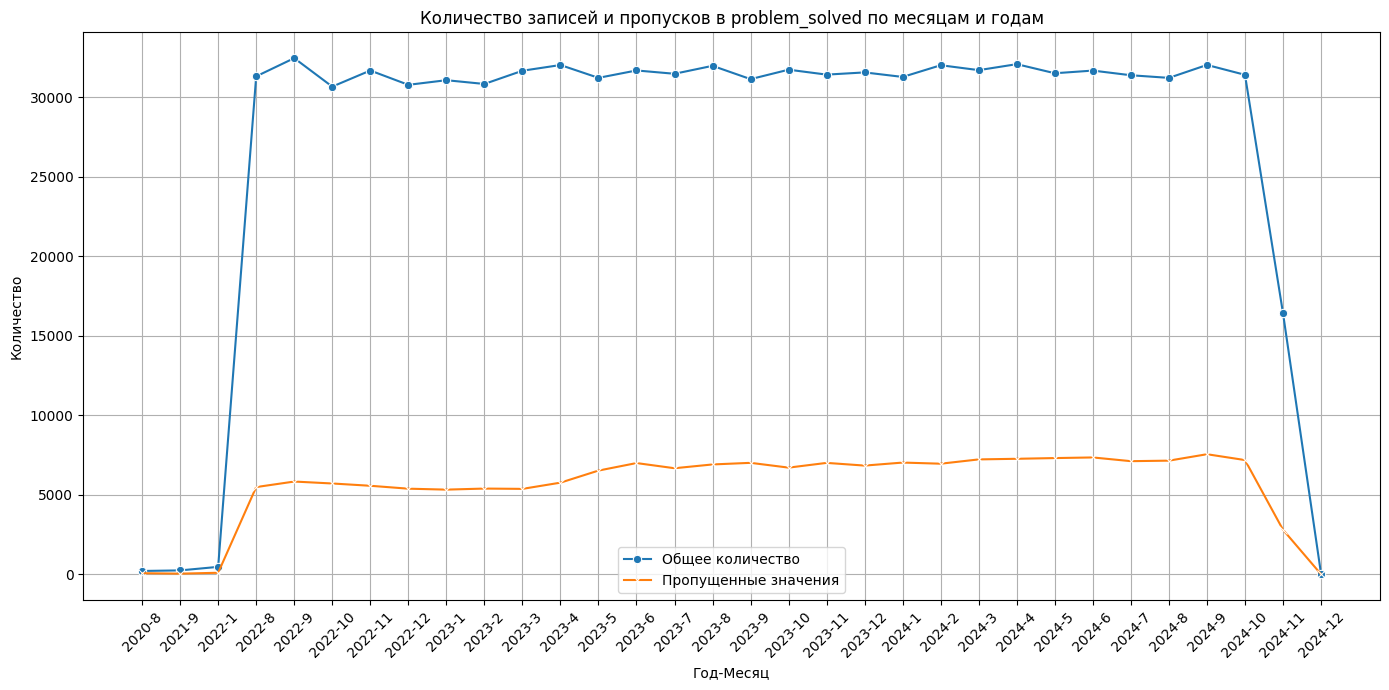

In [126]:
# Посмотрим пропуски в target
period_mapping = {
    'Январь': 1,
    'Февраль': 2,
    'Март': 3,
    'Апрель': 4,
    'Май': 5,
    'Июнь': 6,
    'Июль': 7,
    'Август': 8,
    'Сентябрь': 9,
    'Октябрь': 10,
    'Ноябрь': 11,
    'Декабрь': 12
}

# Применяем маппинг к столбцу 'Период'
df['Период'] = df['Период'].map(period_mapping)

# Группируем данные
grouped_total = df.groupby(['Календарный_год', 'Период'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['Календарный_год', 'Период'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

# Объединяем результаты
result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()

# Создаем составной столбец для оси X (например, "2023-3")
result['Year_Month'] = result['Календарный_год'].astype(str) + '-' + result['Период'].astype(str)

# Строим график
plt.figure(figsize=(14, 7))
sns.lineplot(data=result, x='Year_Month', y='total_count', label='Общее количество', marker='o')
sns.lineplot(data=result, x='Year_Month', y='missing_count', label='Пропущенные значения', marker='x')

plt.xticks(rotation=45)
plt.title('Количество записей и пропусков в problem_solved по месяцам и годам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Удаляем ненужные колонки
# df = df.drop(columns=['respondent_number'])
# TODO посмотреть почему много пропусков
# TODO посмотреть есть ли комментарий

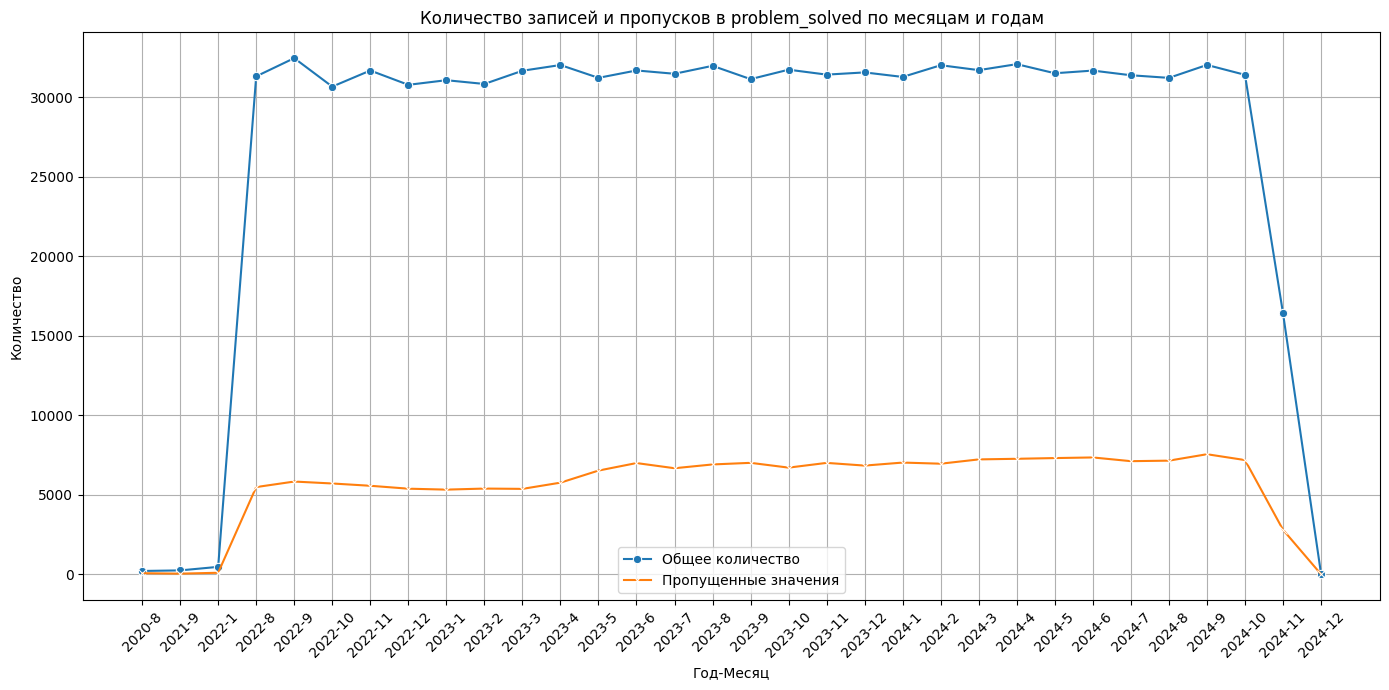

In [128]:

# Группируем данные
grouped_total = df.groupby(['Календарный_год', 'Период'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['Календарный_год', 'Период'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

# Объединяем результаты
result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()

# Создаем составной столбец для оси X (например, "2023-3")
result['Year_Month'] = result['Календарный_год'].astype(str) + '-' + result['Период'].astype(str)

# Строим график
plt.figure(figsize=(14, 7))
sns.lineplot(data=result, x='Year_Month', y='total_count', label='Общее количество', marker='o')
sns.lineplot(data=result, x='Year_Month', y='missing_count', label='Пропущенные значения', marker='x')

plt.xticks(rotation=45)
plt.title('Количество записей и пропусков в problem_solved по месяцам и годам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Удаляем ненужные колонки
# df = df.drop(columns=['respondent_number'])
# TODO посмотреть почему много пропусков
# TODO посмотреть есть ли комментарий

In [129]:
# Проверим, может дело в Регионе
# Группировка с учётом региона
grouped_total = df.groupby(['Календарный_год', 'Период', 'Регион'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['Календарный_год', 'Период', 'Регион'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

# Объединение результатов
result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()

# Сортировка для лучшей читаемости
result = result.sort_values(by=['Календарный_год', 'Период', 'Регион'])

# Вывод результата
print("Таблица с количеством записей и пропусков по регионам:")
print(result.to_string(index=False))


Таблица с количеством записей и пропусков по регионам:
 Календарный_год  Период                                   Регион  total_count  missing_count
            2020       8                       Ростовская область          208             68
            2021       9                       Смоленская область          243             39
            2022       1          Кабардино-Балкарская Республика          227             53
            2022       1                      Республика Калмыкия          239             42
            2022       8                           Алтайский край          503            109
            2022       8                         Амурская область          272              7
            2022       8                    Архангельская область          249             25
            2022       8                     Астраханская область          263             19
            2022       8                     Белгородская область          234             48
     

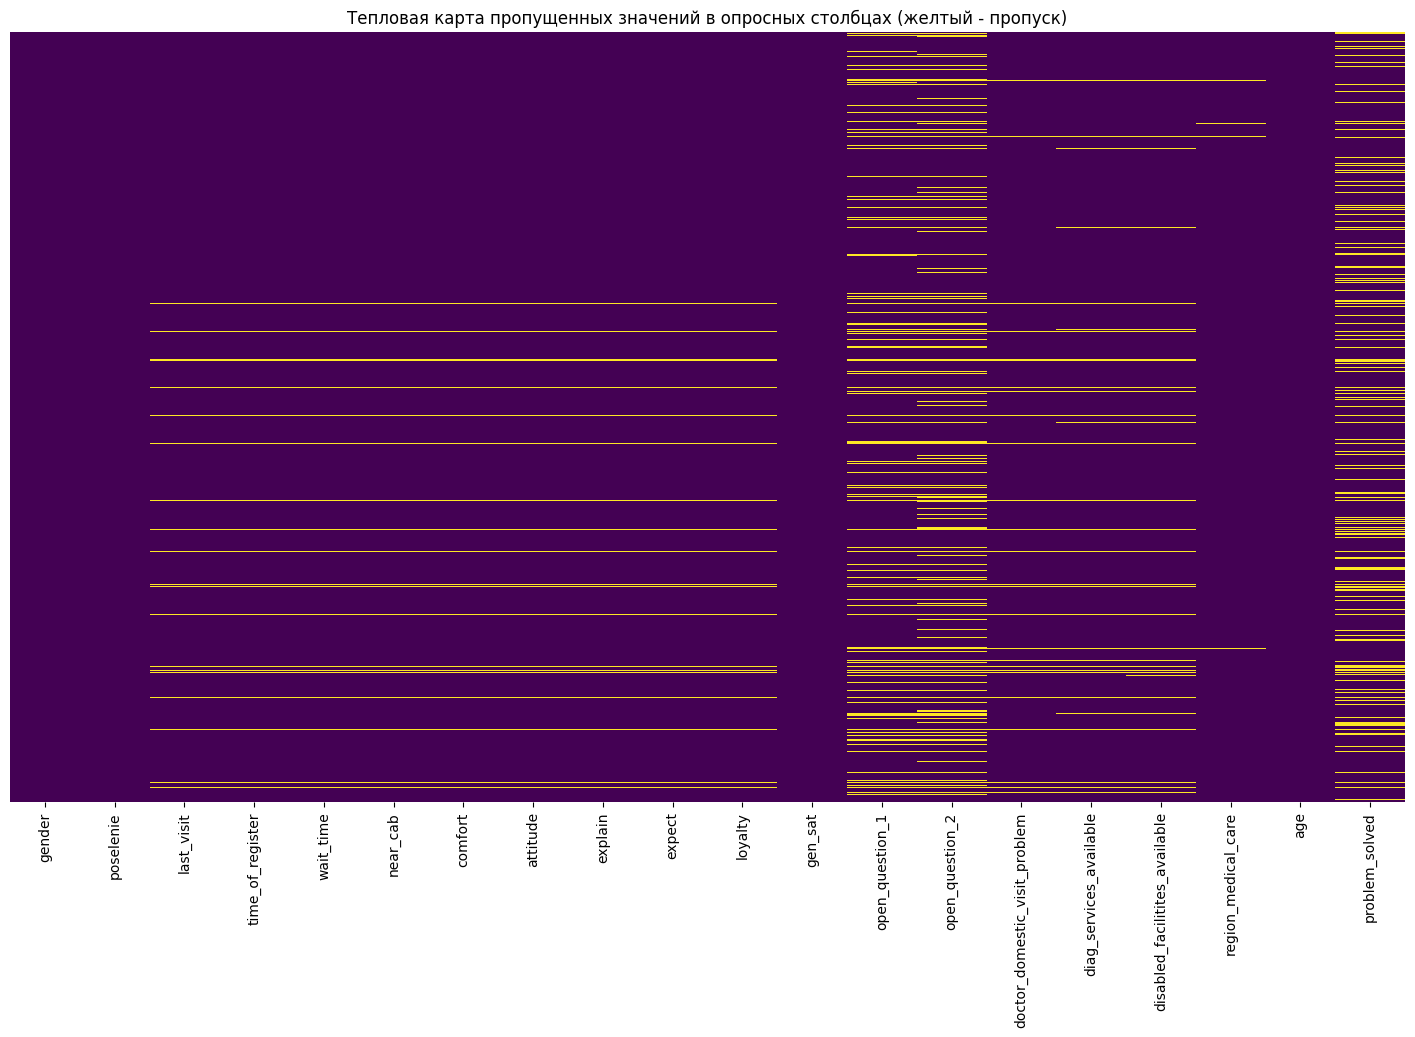

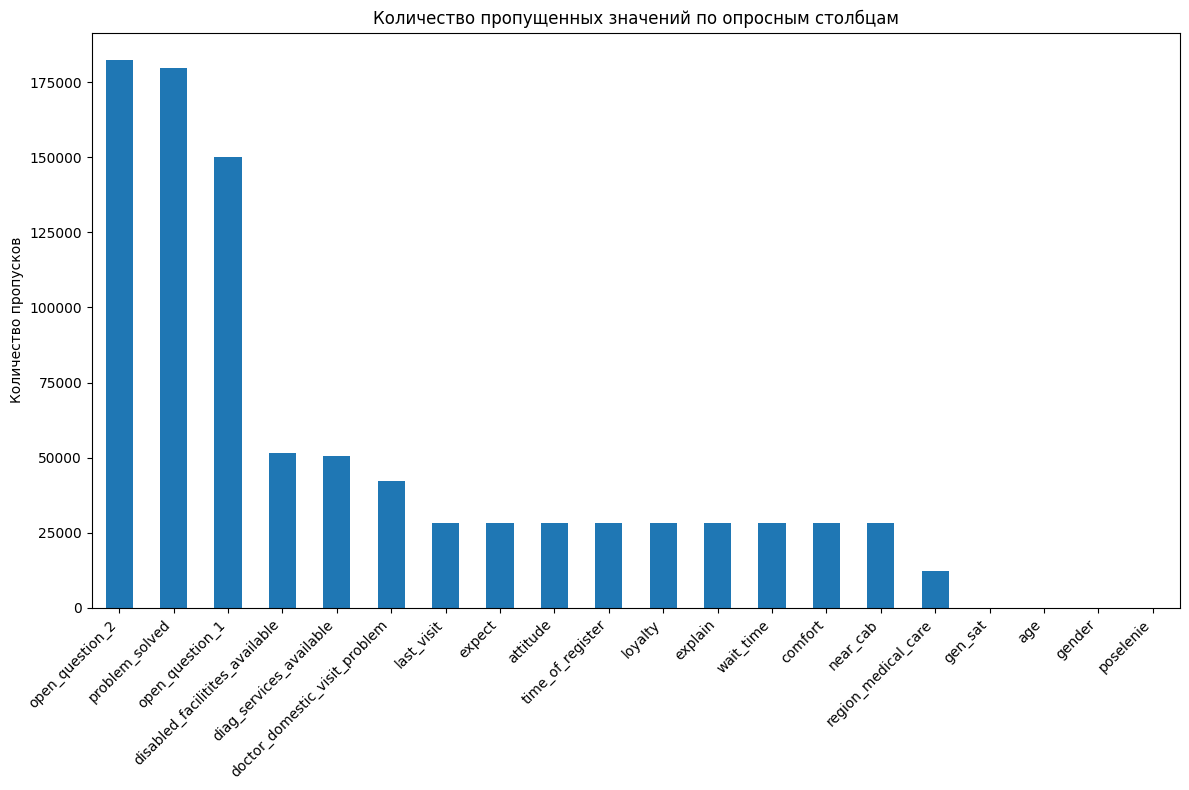

In [130]:
# Посмотрим на пропуски более детально: м.б. строки пустые целиком (т.е. мусор), 
# либо респонденты не ответили на вопросы после того, как посатвили низкую оценку по одному из вопросов (1-2)
df_analysis = df.copy()
# Столбцы, которые НЕ являются оценочными/опросными
id_cols = ['Регион', 'Календарный_год', 'Период', 'date_of_survey', 'respondent_number', 'Населенный_пункт', 'org_type']
# Опросные/оценочные столбцы (все, кроме id_cols)
survey_cols = [col for col in df_analysis.columns if col not in id_cols]
# --- 2. Визуализация общего распределения пропусков ---
plt.figure(figsize=(18, 10))
sns.heatmap(df_analysis[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Тепловая карта пропущенных значений в опросных столбцах (желтый - пропуск)')
plt.show()

missing_counts = df_analysis[survey_cols].isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0] # Только столбцы с пропусками

if not missing_counts.empty:
    plt.figure(figsize=(12, 8))
    missing_counts.plot(kind='bar')
    plt.title('Количество пропущенных значений по опросным столбцам')
    plt.ylabel('Количество пропусков')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Пропусков в опросных столбцах не найдено.")


Анализ пропусков для: Год=2024, Период='8', Регион='Новосибирская область'
Найдено записей после фильтрации: 611


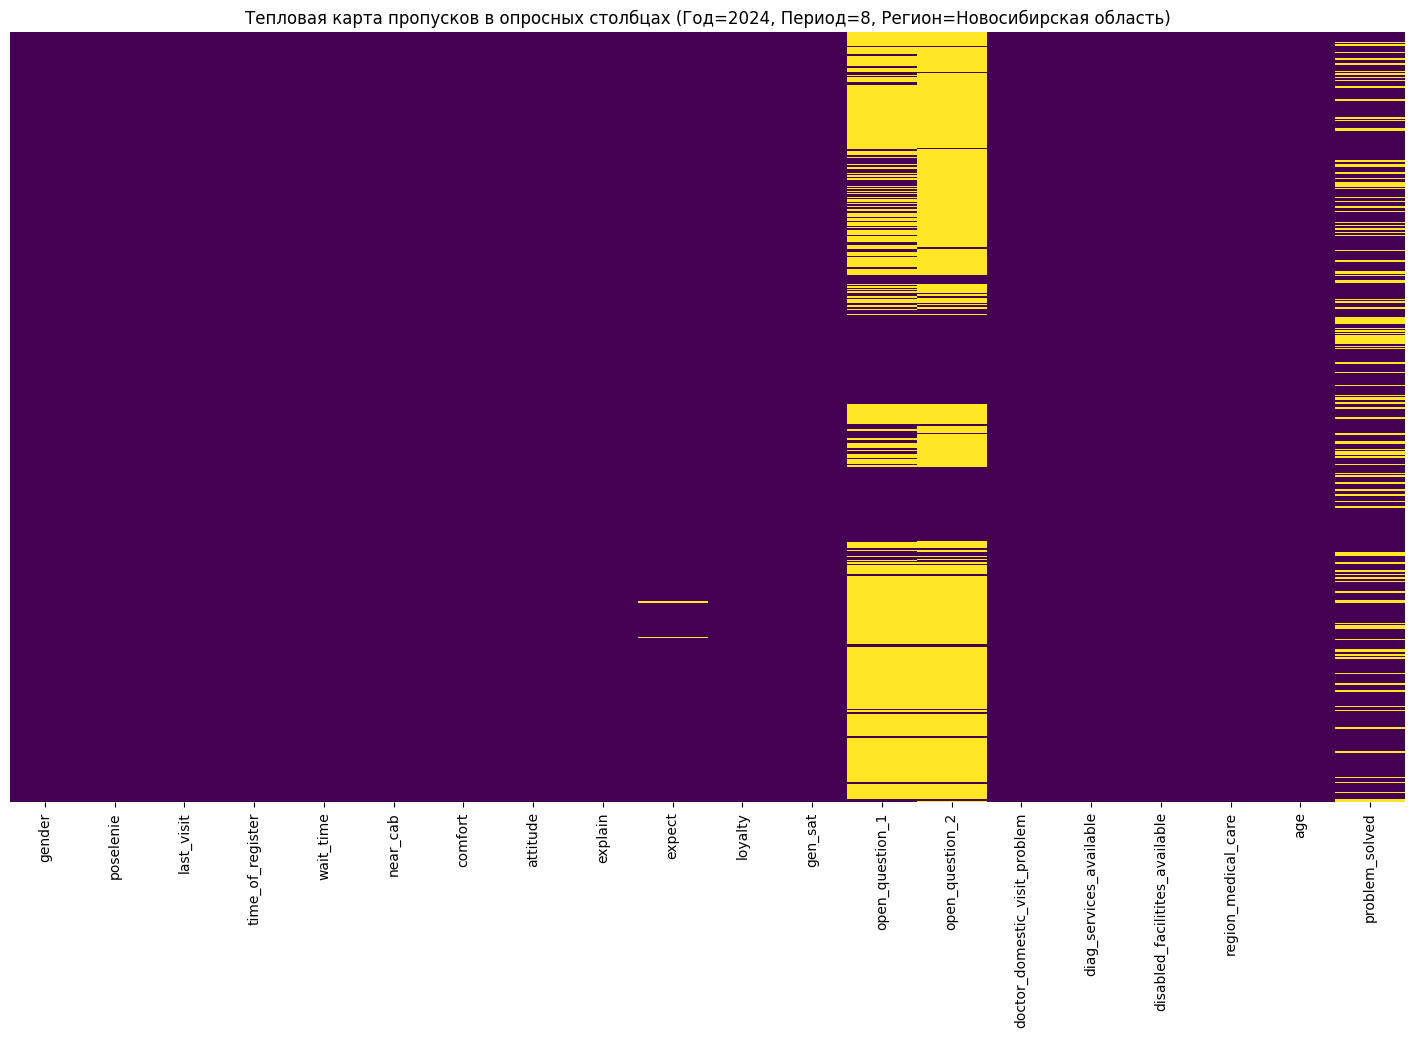

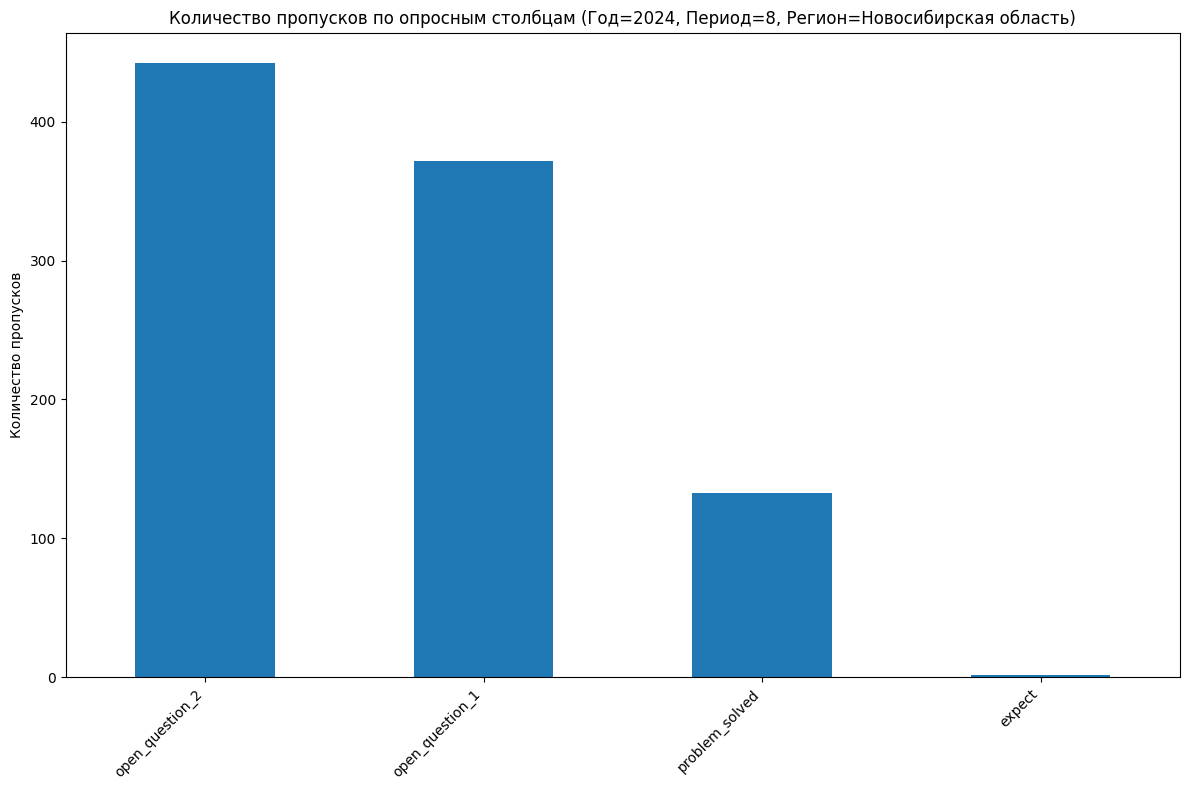

In [139]:
# Фильтрация данных для 2023 года, Декабрь, Московская область
year_filter_specific = 2024
period_filter_specific = 8 # Убедитесь, что значение соответствует данным в столбце 'Период'
region_filter_specific = 'Новосибирская область' # Убедитесь, что значение соответствует данным в столбце 'Регион'

# Предполагается, что df_analysis и survey_cols определены в предыдущей ячейке (cell 12)
df_filtered_specific = df_analysis[
    (df_analysis['Календарный_год'] == year_filter_specific) &
    (df_analysis['Период'] == period_filter_specific) &
    (df_analysis['Регион'] == region_filter_specific)
]

print(f"\nАнализ пропусков для: Год={year_filter_specific}, Период='{period_filter_specific}', Регион='{region_filter_specific}'")
print(f"Найдено записей после фильтрации: {len(df_filtered_specific)}")

if df_filtered_specific.empty:
    print("Не найдено данных для указанных фильтров. Диаграммы не будут построены.")
else:
    # --- 1. Визуализация общего распределения пропусков для отфильтрованных данных ---
    plt.figure(figsize=(18, 10))
    sns.heatmap(df_filtered_specific[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title(f'Тепловая карта пропусков в опросных столбцах (Год={year_filter_specific}, Период={period_filter_specific}, Регион={region_filter_specific})')
    plt.show()

    # --- 2. Визуализация количества пропусков по столбцам для отфильтрованных данных ---
    missing_counts_specific = df_filtered_specific[survey_cols].isnull().sum().sort_values(ascending=False)
    missing_counts_specific = missing_counts_specific[missing_counts_specific > 0] # Только столбцы с пропусками

    if not missing_counts_specific.empty:
        plt.figure(figsize=(12, 8))
        missing_counts_specific.plot(kind='bar')
        plt.title(f'Количество пропусков по опросным столбцам (Год={year_filter_specific}, Период={period_filter_specific}, Регион={region_filter_specific})')
        plt.ylabel('Количество пропусков')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Пропусков в опросных столбцах для указанных фильтров (Год={year_filter_specific}, Период={period_filter_specific}, Регион={region_filter_specific}) не найдено.")



Найдено 0 строк, где все опросные столбцы пустые.

Найдено 4105 строк, где потенциально низкая оценка в 'gen_sat' и анкета не закончена.
Примеры таких строк (идентификаторы, 'gen_sat', кол-во пропусков):
                               Регион  Календарный_год  Период           date_of_survey  respondent_number Населенный_пункт org_type  gen_sat  missing_in_survey_cols
369739  Луганская Народная Республика             2023       5  2023-05-31 00:00:00.000            381.000       г. Луганск      NaN    1.000                      15
369757  Луганская Народная Республика             2023       5  2023-05-31 00:00:00.000            399.000       г. Луганск      NaN    2.000                      15
369764  Луганская Народная Республика             2023       5  2023-05-31 00:00:00.000            406.000       г. Луганск      NaN    2.000                      15
369777  Луганская Народная Республика             2023       5  2023-05-31 00:00:00.000            419.000  г. Северодонецк      Na

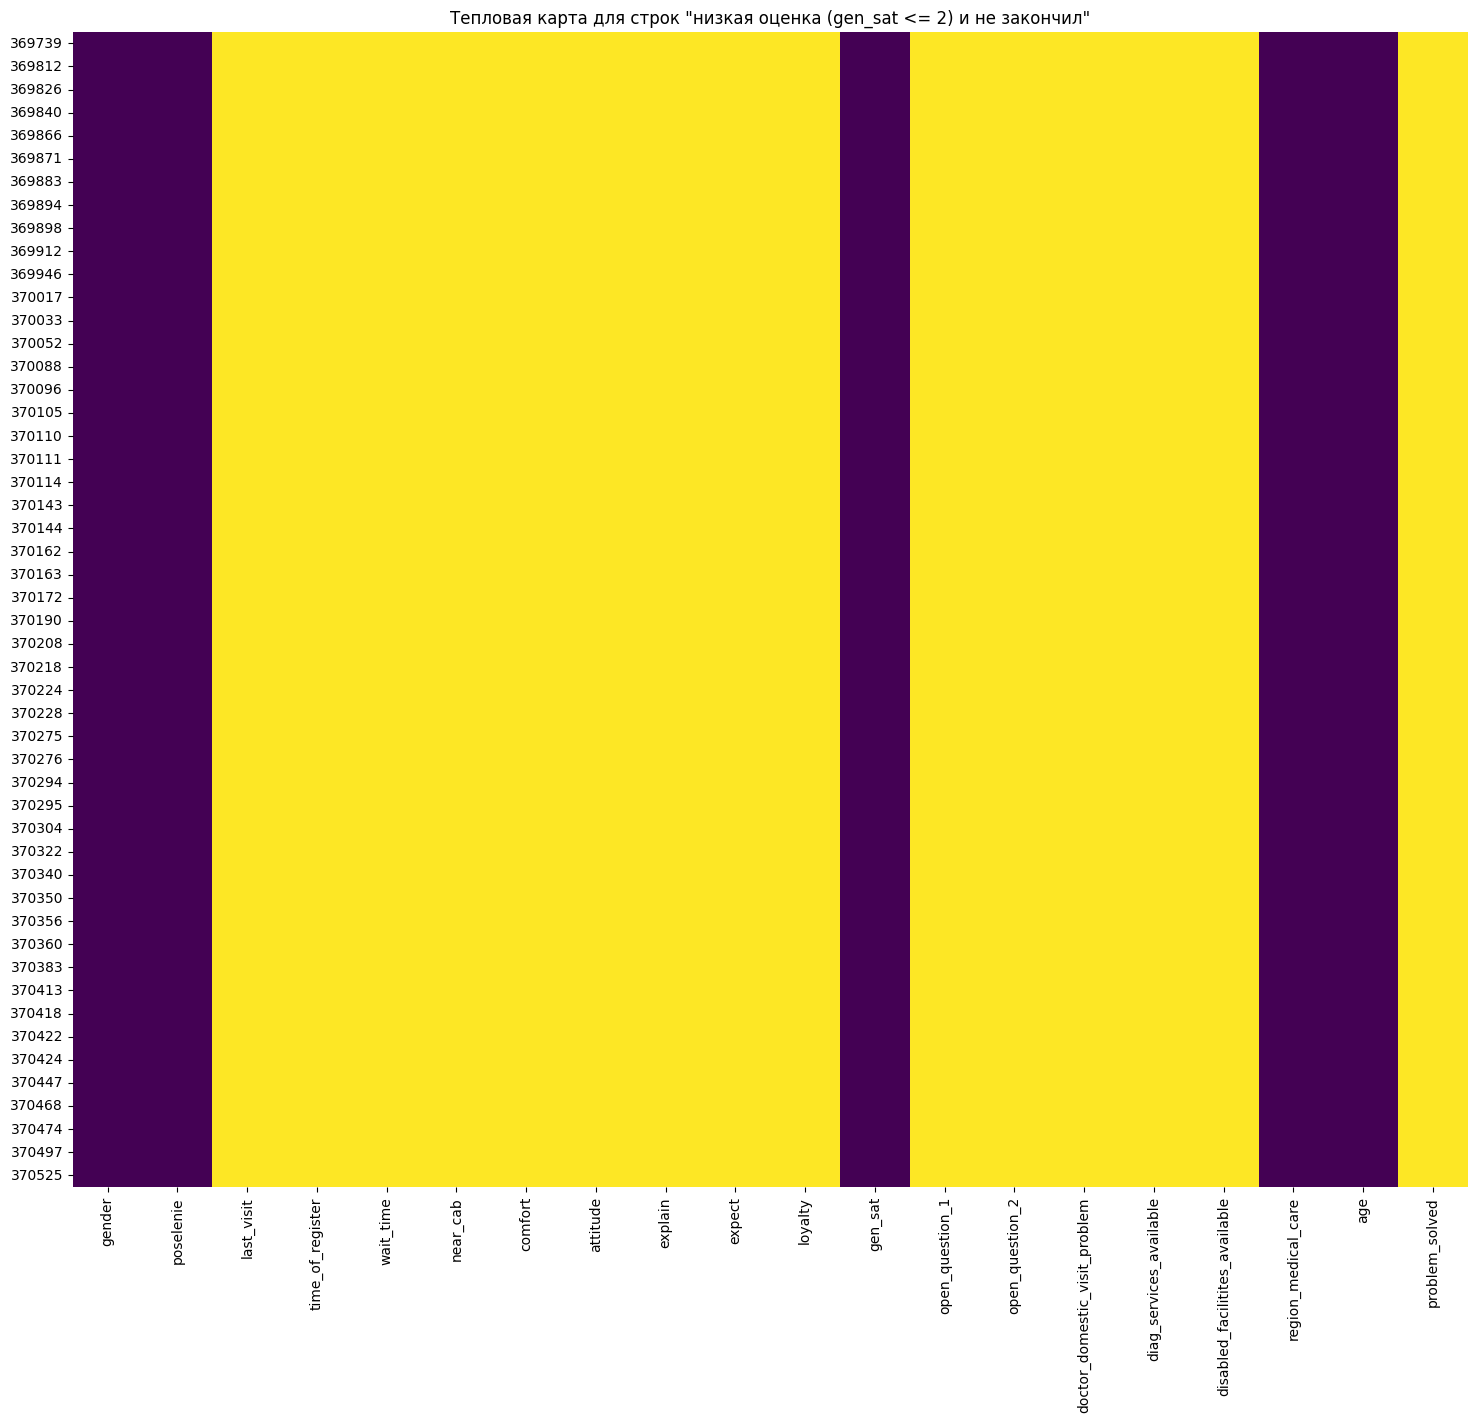

In [105]:
# --- 3. Выявление и визуализация "полностью пустых" строк ---
df_analysis['missing_in_survey_cols'] = df_analysis[survey_cols].isnull().sum(axis=1)
fully_empty_rows_mask = df_analysis['missing_in_survey_cols'] == len(survey_cols)
df_fully_empty = df_analysis[fully_empty_rows_mask]

print(f"\nНайдено {len(df_fully_empty)} строк, где все опросные столбцы пустые.")
if not df_fully_empty.empty:
    print("Примеры таких строк (только идентификационные столбцы):")
    print(df_fully_empty[id_cols].head())
    
    # Тепловая карта для этих "полностью пустых" строк (если их не слишком много)
    if 0 < len(df_fully_empty) < 50: # Ограничение для читаемости
        plt.figure(figsize=(18, max(5, len(df_fully_empty) * 0.3)))
        sns.heatmap(df_fully_empty[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=True)
        plt.title(f'Тепловая карта для {len(df_fully_empty)} "полностью пустых" строк (в опросных столбцах)')
        plt.show()

# --- 4. Выявление строк "низкая оценка и не закончил" ---
# Это требует адаптации под ваши данные!
# Предположим, 'gen_sat' (общая удовлетворенность) - ключевой столбец для "низкой оценки"
# и оценки там числовые (например, от 1 до 5).
# Если 'gen_sat' текстовый, его нужно будет сначала преобразовать.

key_evaluation_col = 'gen_sat' # Замените на ваш ключевой столбец
low_score_threshold = 2       # Пример: оценки 1 или 2 считаются низкими
min_subsequent_empty_cols = 3 # Пример: если хотя бы 3 следующих столбца пусты

# Попытка сконвертировать в числовой тип, игнорируя ошибки (нечисловые станут NaT/NaN)
# ВАЖНО: адаптируйте это под формат ваших данных в 'gen_sat'
if key_evaluation_col in survey_cols:
    df_analysis[key_evaluation_col + '_numeric'] = pd.to_numeric(df_analysis[key_evaluation_col], errors='coerce')

    # Ищем строки с низкой оценкой
    low_score_mask = (df_analysis[key_evaluation_col + '_numeric'] <= low_score_threshold)
    
    # Теперь для этих строк смотрим, сколько пропусков в "остальной" части анкеты
    # Это можно сделать по-разному. Более простой способ:
    # если общее количество пропусков в survey_cols для этой строки больше определенного порога
    min_total_missing_for_incomplete = len(survey_cols) * 0.5 # Например, если больше 50% опросных полей пустые

    incomplete_mask = df_analysis['missing_in_survey_cols'] >= min_total_missing_for_incomplete
    
    df_low_score_incomplete = df_analysis[low_score_mask & incomplete_mask]
    
    print(f"\nНайдено {len(df_low_score_incomplete)} строк, где потенциально низкая оценка в '{key_evaluation_col}' и анкета не закончена.")

    if not df_low_score_incomplete.empty:
        print(f"Примеры таких строк (идентификаторы, '{key_evaluation_col}', кол-во пропусков):")
        print(df_low_score_incomplete[id_cols + [key_evaluation_col, 'missing_in_survey_cols']].head())

        # Сортируем для лучшей визуализации паттерна
        df_low_score_incomplete_sorted = df_low_score_incomplete.sort_values(
            by=[key_evaluation_col + '_numeric', 'missing_in_survey_cols'],
            ascending=[True, False]
        )
        
        # Ограничим количество строк для отображения на тепловой карте
        display_limit = 50 
        if len(df_low_score_incomplete_sorted) > display_limit:
            print(f"Отображаем первые {display_limit} из {len(df_low_score_incomplete_sorted)} строк на тепловой карте.")
            df_to_display = df_low_score_incomplete_sorted.head(display_limit)
        else:
            df_to_display = df_low_score_incomplete_sorted

        if not df_to_display.empty:
            plt.figure(figsize=(18, max(8, len(df_to_display) * 0.3)))
            sns.heatmap(df_to_display[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=True)
            plt.title(f'Тепловая карта для строк "низкая оценка ({key_evaluation_col} <= {low_score_threshold}) и не закончил"')
            plt.show()
else:
    print(f"\nКлючевой столбец для оценки '{key_evaluation_col}' не найден среди опросных столбцов или не удалось обработать.")

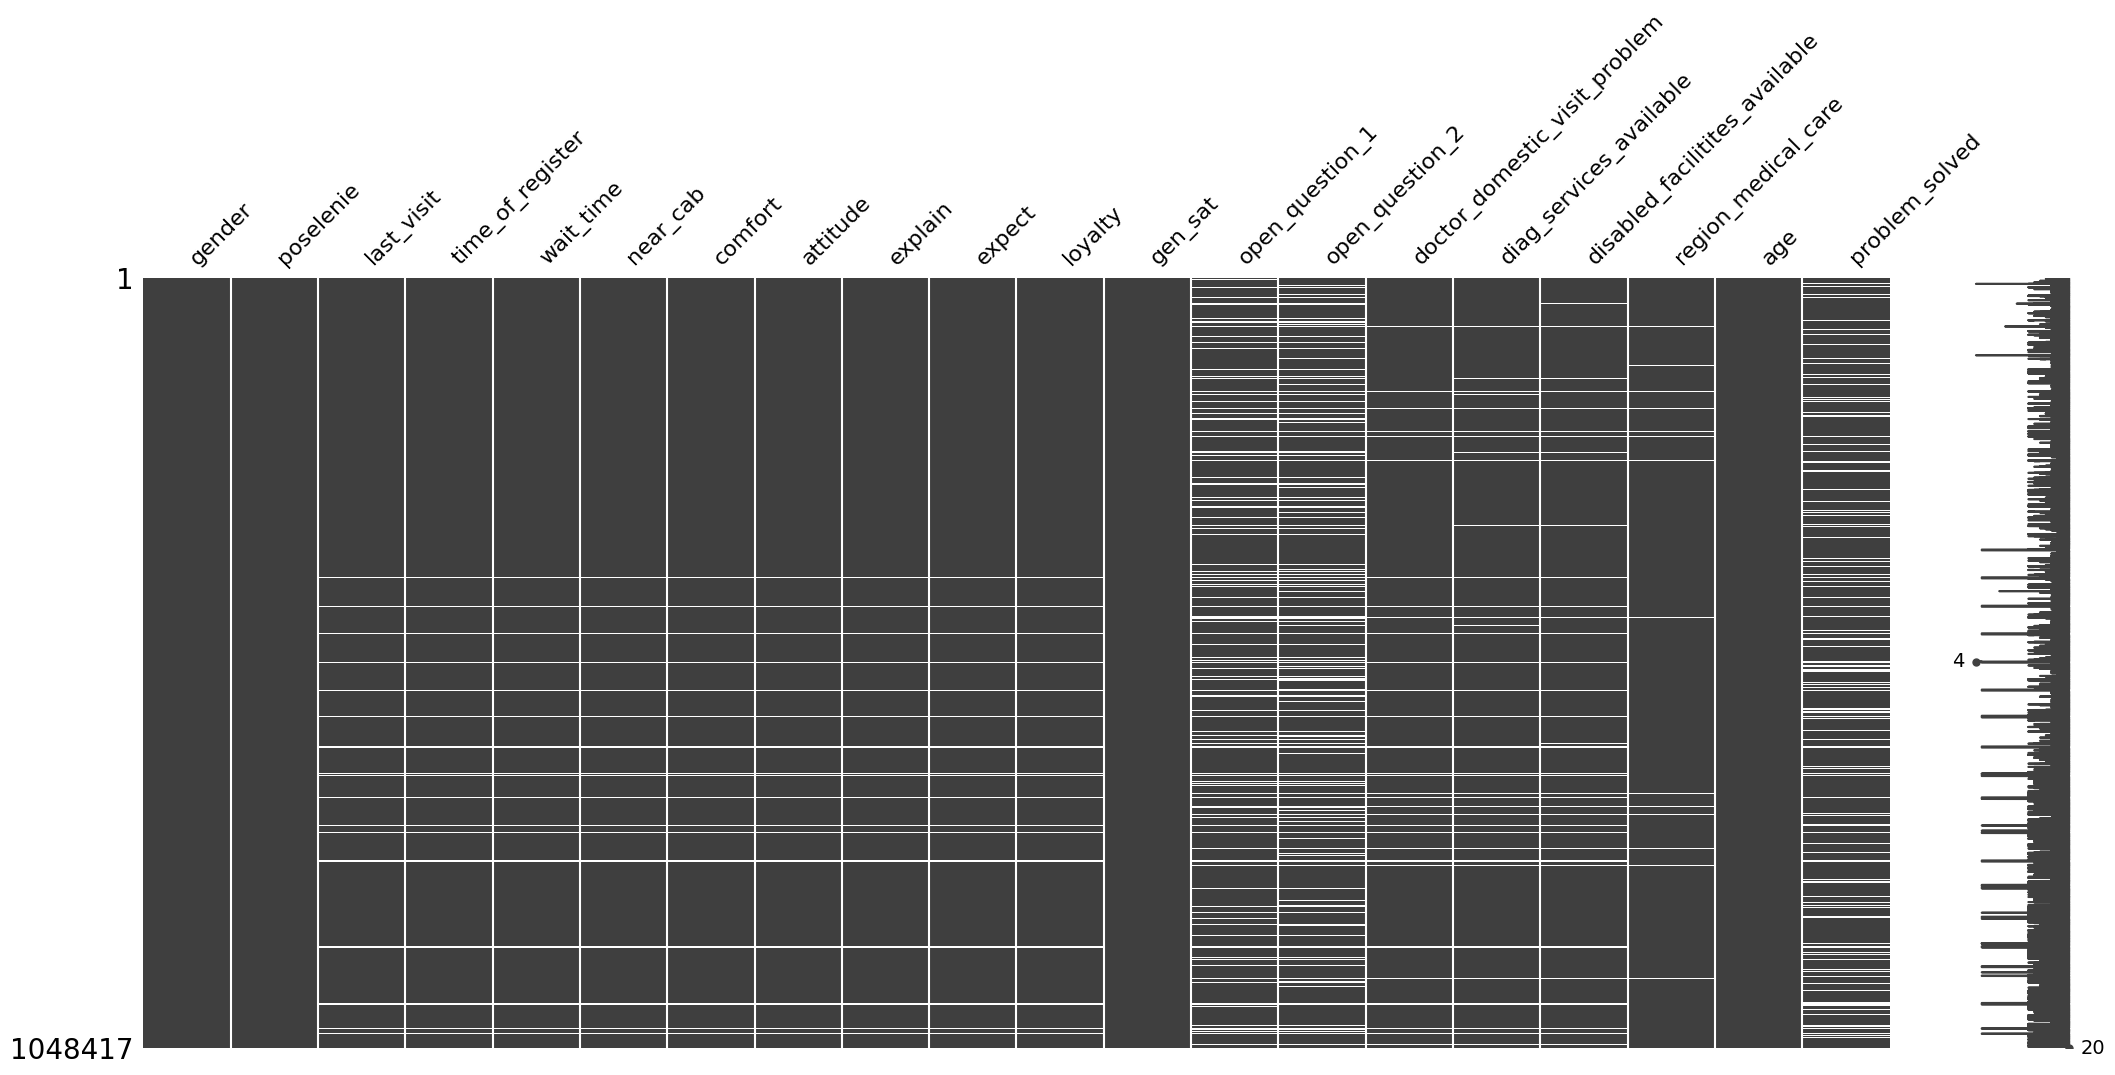

In [106]:
import missingno as msno
msno.matrix(df[survey_cols])
plt.show()


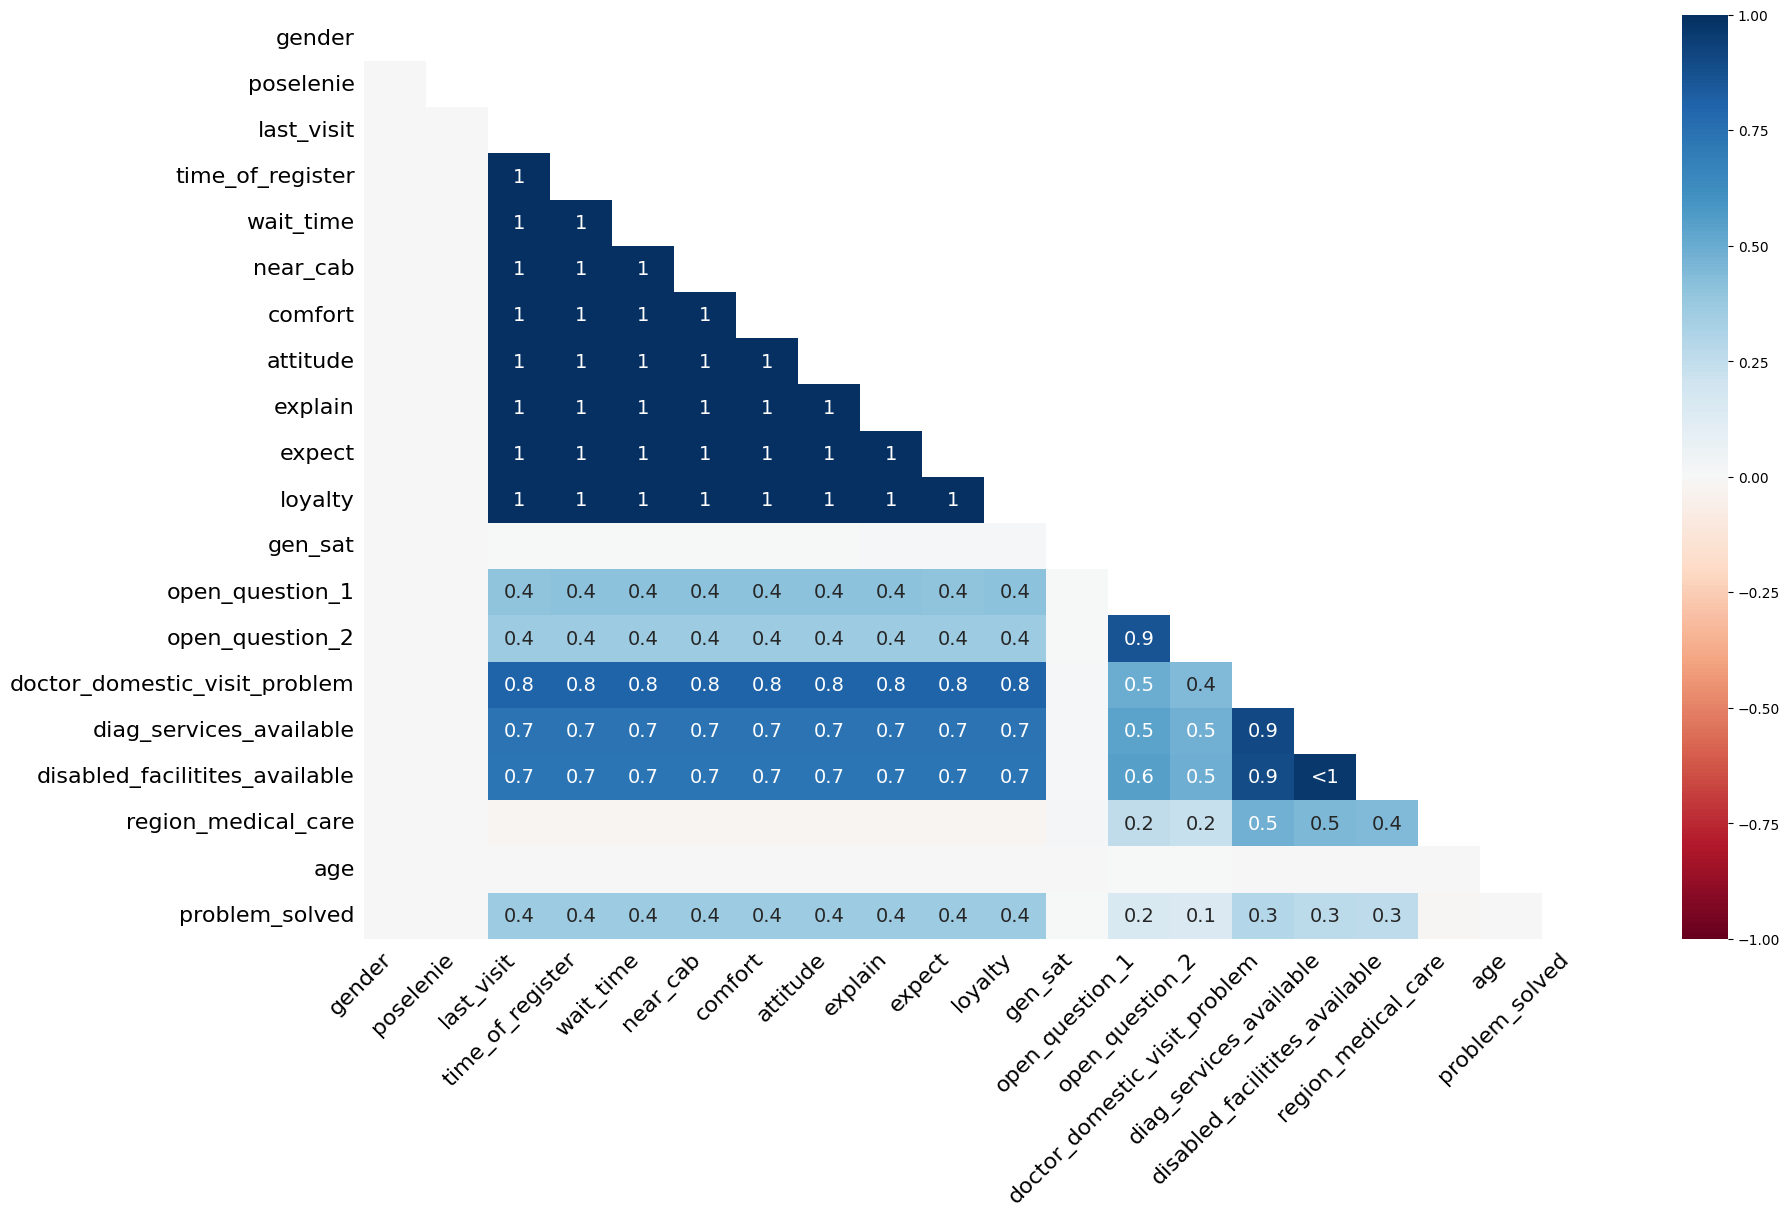

In [107]:

msno.heatmap(df[survey_cols])
plt.show()

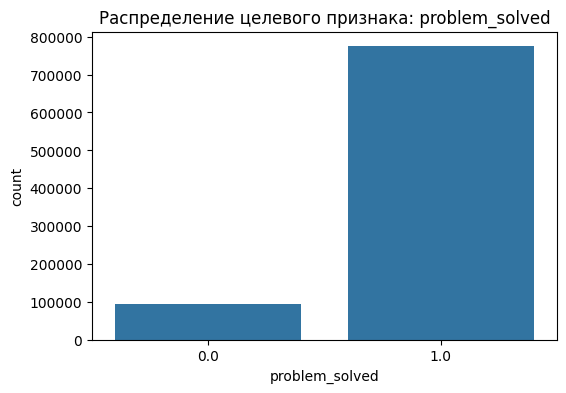

In [108]:
# Распределение целевого признака
plt.figure(figsize=(6, 4))
sns.countplot(x='problem_solved', data=df)
plt.title('Распределение целевого признака: problem_solved')
plt.show()

In [109]:
# TODO дисбаланс

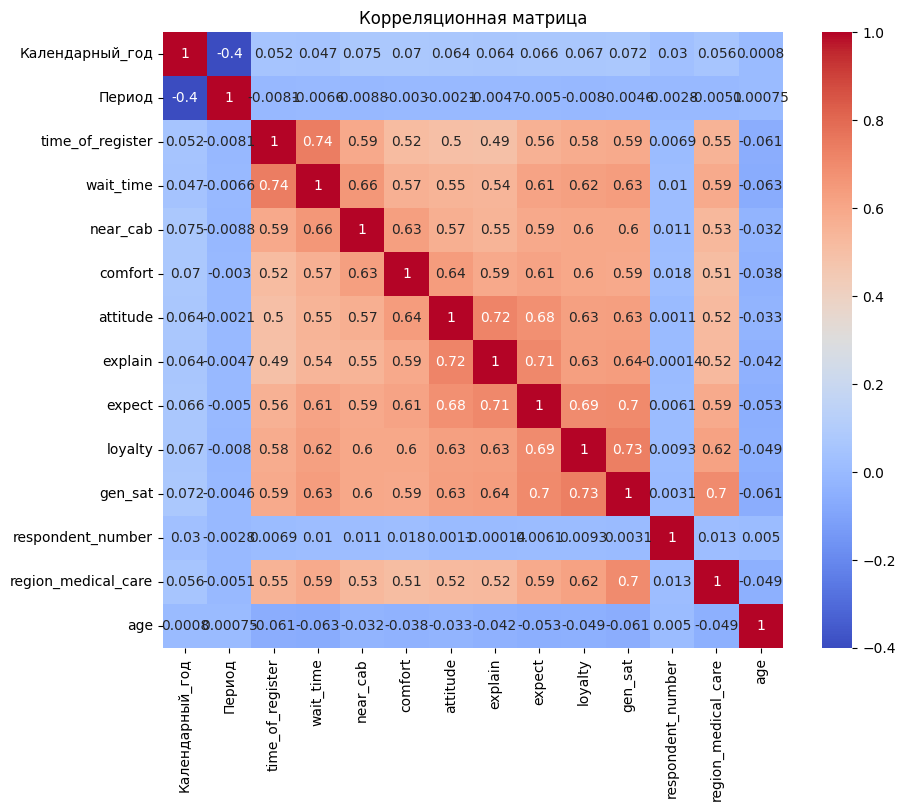

In [110]:
# Корреляция числовых признаков
numeric_cols = df.select_dtypes(include=np.number).drop(columns=['problem_solved']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

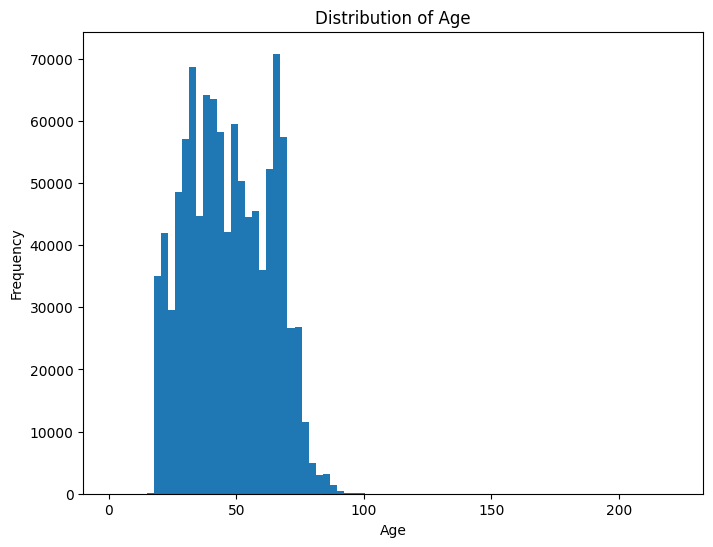

In [111]:
plt.figure(figsize=(8, 6))
df['age'].plot(kind='hist', bins=80)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()
# TODO Можно также посмотреть как меняется возраст в завсисмости от региона и даты

In [112]:
# TODO проверить гипотезу от разной значимости признаков для женщин и мужчин, также для разных возрастов

In [113]:
# TODO могут быть подозрительные данные, когда ту же самую анекету залили в следующем периоде

In [114]:
# TODO доделать преобразование в координаты и создание карты
# df.drop_duplicates(inplace=True)
#df_sample = df.sample(n=10).copy()

In [115]:
'''
# Инициализация геокодера
geolocator = Nominatim(user_agent="geo_example")

# Название села
# location = geolocator.geocode("село Лопатино, Россия")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_sample['geo_coordinates'] = df_sample['Населенный_пункт'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))


df_sample['latitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.latitude if loc else None)
df_sample['longitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.longitude if loc else None)


display(df_sample.head())


missing_coordinates_count = df_sample['geo_coordinates'].isnull().sum()
print(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")
'''

'\n# Инициализация геокодера\ngeolocator = Nominatim(user_agent="geo_example")\n\n# Название села\n# location = geolocator.geocode("село Лопатино, Россия")\n\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)\n\ndf_sample[\'geo_coordinates\'] = df_sample[\'Населенный_пункт\'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))\n\n\ndf_sample[\'latitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.latitude if loc else None)\ndf_sample[\'longitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.longitude if loc else None)\n\n\ndisplay(df_sample.head())\n\n\nmissing_coordinates_count = df_sample[\'geo_coordinates\'].isnull().sum()\nprint(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")\n'

In [116]:
# TODO обработать текст open_question_1 и open_question_2

### Feature Engineering

In [75]:
# 1. Средняя удовлетворенность по всем шкалам
satisfaction_columns = ['time_of_register', 'wait_time', 'near_cab', 'comfort',
                        'attitude', 'explain', 'expect']
df['avg_satisfaction'] = df[satisfaction_columns].mean(axis=1)

# 2. Возрастные группы
# bins = [0, 18, 30, 45, 60, 100]
# labels = ['<18', '18-30', '31-45', '46-60', '>60']
# df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# 3. Месяц из даты опроса
df['date_of_survey'] = pd.to_datetime(df['date_of_survey'], errors='coerce')
df['survey_date_month'] = pd.to_datetime(df['date_of_survey']).dt.month

# 4. Длительность последнего визита (переводим в месяцы)
visit_map = {
    'менее 1 мес. назад': 0.5,
    'от 1 до 3 мес. назад': 2,
    'от 4 до 6 мес. назад': 5,
    'от 7 до 12 мес. назад': 9.5,
    'более 12 мес. назад': 15
}
df['last_visit_months'] = df['last_visit'].map(visit_map)
# проеверить NaN

# 5. Наличие проблем с вызовом врача на дом
df['has_home_visit_problem'] = df['doctor_domestic_visit_problem'].apply(lambda x: 1 if x == 'Да' else 0)

# 6. Есть ли диагностические услуги
df['diag_available'] = df['diag_services_available'].apply(lambda x: 1 if x == 'Да' else 0)

# 7. Наличие удобств для инвалидов
df['disabled_facilities'] = df['disabled_facilitites_available'].apply(lambda x: 1 if x == 'Да' else 0)

# 8. Город/село
df['is_urban'] = df['poselenie'].map({'Город': 1, 'Село': 0})

# 9. Частота обращений (обратная величина last_visit_months)
df['visit_frequency'] = 1 / (df['last_visit_months'] + 0.1)

# 10. Тип организации (государственная или нет)
df['org_type'] = df['org_type'].fillna('Преимущественно в государственных')
df['is_state_org'] = df['org_type'].str.contains('государственных').astype(int)

In [78]:
df.head()

,Регион,Календарный_год,Период,gender,poselenie,Населенный_пункт,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved,avg_satisfaction,age_group,survey_date_month,last_visit_months,has_home_visit_problem,diag_available,disabled_facilities,is_urban,visit_frequency,is_state_org
0,Краснодарский край,2023,Январь,Мужской,Город,Приморско-Ахтарск,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,5.000,5.000,6.000,6.000,6.000,5.000,6.000,6,-,-,2023-01-23,Нет,Да,Да,6.000,61.000,1,5.429,>60,1.000,5.000,0,1,1,1,0.196,1
1,Краснодарский край,2023,Январь,Мужской,Город,Краснодар,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,5.000,5.000,4.000,5.000,5.000,6.000,5.000,5,-,-,2023-01-23,Нет,Да,Да,5.000,67.000,1,5.000,>60,1.000,5.000,0,1,1,1,0.196,1
2,Краснодарский край,2023,Январь,Мужской,Город,Краснодар,Преимущественно в государственных,от 1 до 3 мес. назад,4.000,5.000,5.000,4.000,5.000,5.000,4.000,5.000,5,-,-,2023-01-23,Нет,Да,Да,5.000,71.000,1,4.571,>60,1.000,2.000,0,1,1,1,0.476,1
3,Краснодарский край,2023,Январь,Мужской,Город,Сочи,Только в частных,более 12 мес. назад,5.000,6.000,6.000,6.000,5.000,6.000,6.000,6.000,6,-,-,2023-01-23,Не пользовался данной услугой,Да,Да,6.000,33.000,1,5.714,31-45,1.000,15.000,0,1,1,1,0.066,0
4,Краснодарский край,2023,Январь,Мужской,Город,Туапсе,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,6.000,5.000,6.000,6.000,6.000,6.000,5.000,6,-,-,2023-01-23,Нет,Да,Да,6.000,49.000,1,5.714,46-60,1.000,5.000,0,1,1,1,0.196,1


### Baseline модель

In [86]:
# Удаление лишних столбцов
X = df.drop(columns=['poselenie', 'org_type', 'problem_solved', 'open_question_1', 'open_question_2', 'date_of_survey', 'doctor_domestic_visit_problem', 'diag_services_available', 'disabled_facilitites_available', 'last_visit', 'Период', 'gender', 'Населенный_пункт'])
y = df['problem_solved']

categorical_cols = ['Регион', 'time_of_register', 'wait_time', 'near_cab', 'comfort', 'attitude', 'explain', 'expect', 'loyalty', 'gen_sat', 'region_medical_care', 'survey_date_month', 'last_visit_months', 'has_home_visit_problem', 'diag_available', 'disabled_facilities', 'is_urban', 'is_state_org']
numerical_cols = ['age', 'avg_satisfaction', 'visit_frequency']


target_encoder = Pipeline([
    ('wrapper', PolynomialWrapper(TargetEncoder())) 
])

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols[1:]),
    ('target', target_encoder, ['Регион'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [88]:
X_train_prepared = pipeline.fit_transform(X_train, y_train)
X_test_prepared = pipeline.transform(X_test)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [89]:
X_train_prepared.shape

(132161, 21)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.41      0.52      3167
           1       0.94      0.99      0.96     29874

    accuracy                           0.93     33041
   macro avg       0.84      0.70      0.74     33041
weighted avg       0.92      0.93      0.92     33041

ROC AUC Score: 0.8955074844501627


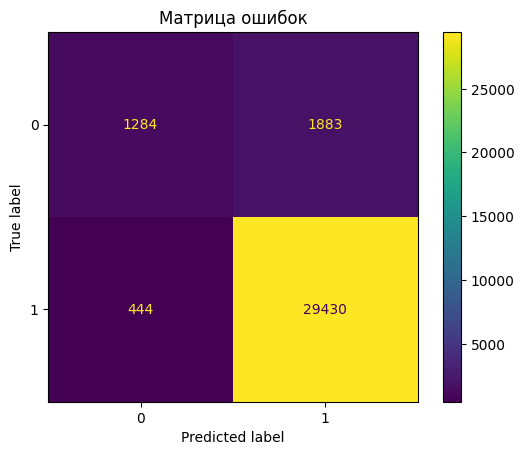

In [91]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_prepared, y_train)
y_pred = model.predict(X_test_prepared)
y_proba = model.predict_proba(X_test_prepared)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_estimator(model, X_test_prepared, y_test)
plt.title("Матрица ошибок")
plt.show()

In [ ]:
# добавить подбор гиперпараметров

In [ ]:
# TODO Графики ROC-AUC, PR AUC, гистограмма скоров, precision, recall, f1-score от порога, f01, f05, f2, f5. Какая b на что обращает больше внимание (MLFLOW)

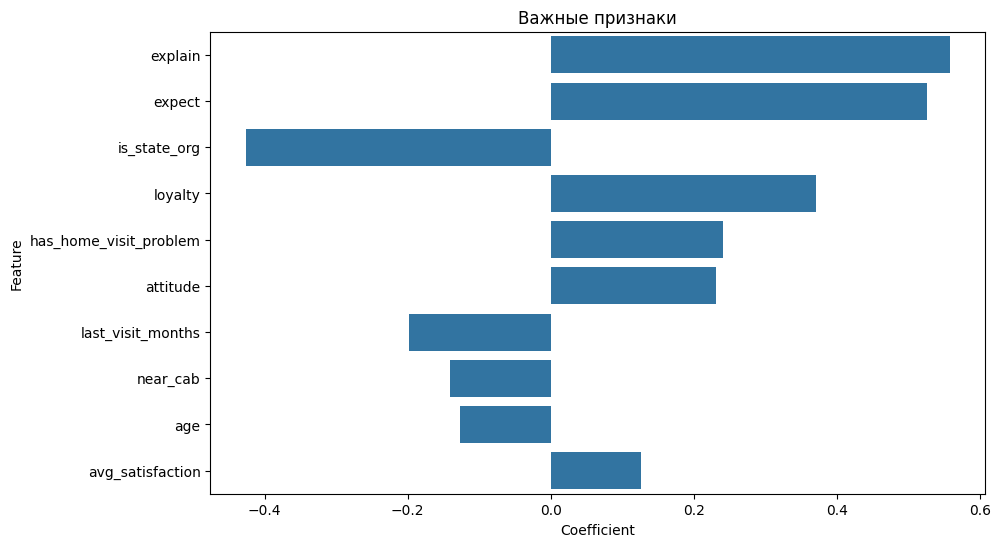

In [93]:
top_features = numerical_cols + categorical_cols

coefs = model.coef_[0]
coef_df = pd.DataFrame(zip(top_features, coefs), columns=["Feature", "Coefficient"])
coef_df["abs_coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Важные признаки")
plt.show()

In [95]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/") 
mlflow.set_experiment("Medical_Survey_Analysis")

with mlflow.start_run():
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))
    mlflow.log_metric("accuracy", model.score(X_test_prepared, y_test))
    
    # Сохраняем модель
    mlflow.sklearn.log_model(model, "model")

2025/05/24 09:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run capable-conch-73 at: http://127.0.0.1:5000/#/experiments/428328559253118491/runs/813cd1e902b94f0196f2c75be1bff4c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/428328559253118491


In [ ]:
# TODO написать функцию для передачи модели в mlflow

In [ ]:
# TODO обучать модель внутри контекта